# Use of machine learning for anomaly detection in netflow data

Threshold based alerting on netflow data has been proved to be ineffective even for a binary classification for DDoS/not DDoS flows.

This brief investigation wants to show that common patterns emerge from analysis on aggregated netflow data that can allow automatic identification of such patterns using machine learning.

Data comes from aggregated flows of core routers of a cloud service provider taken using `nfdump` with `-l 1000` parameter that ignores fluxes with less that 1k packets.
Training data has been collected within 2 weeks of observation.

K nearest neighbors algorithm has been choosen for its easy implementation properties and its effectiveness in clustering on numeric features.

Considered *features* were:
- duration
- number of flows
- total number of packets
- total bytes
- packets per second
- bit per second
- bit per packet

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import mangle

In [3]:
rows = mangle.parse_netflow_csv("data/smtp.csv")
smtp_label = mangle.compose_dict(rows)
rows = mangle.parse_netflow_csv("data/http.csv")
http_label = mangle.compose_dict(rows)
rows = mangle.parse_netflow_csv("data/tivoli.csv")
tivoli_label = mangle.compose_dict(rows)
rows = mangle.parse_netflow_csv("data/small-flood.csv")
small_flood_label = mangle.compose_dict(rows)
rows = mangle.parse_netflow_csv("data/incoming-floods.csv")
incoming_floods_label = mangle.compose_dict(rows)

## Supervised classification

### Typical, non problematic flows scatter plot

This graph represents typical, not abnormal flows manually labeled from top ten output of `nfdump -l 1000 -s dstip/pps/bps`   

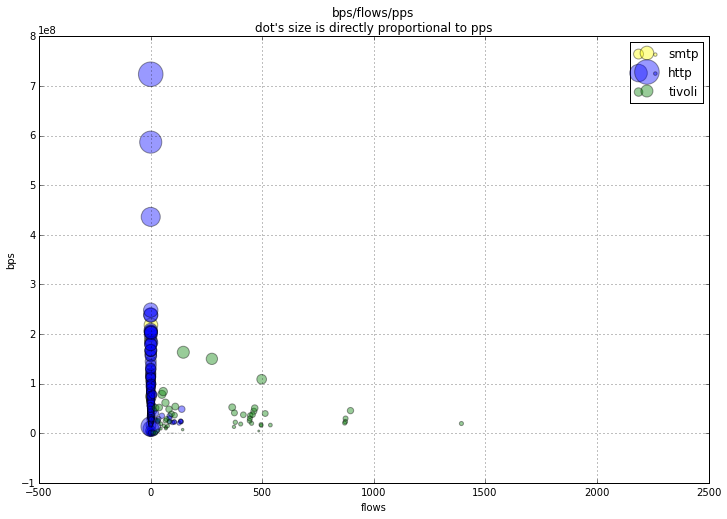

In [13]:
font = {
        'weight' : 'normal',
        'size'   : 16,
        }
plt.figure(figsize=(12,8), dpi=800)
scale_factor = 0.01
alfa = 0.4
plt.xlabel('flows')
plt.ylabel('bps')

# SMTP label
x, y = smtp_label['flows'], smtp_label['bps']
scale = scale_factor * smtp_label['pps']
plt.scatter(x, y, c='yellow', s=scale, label='smtp',
            alpha=alfa, 
            edgecolors='black',
)
# http label
x, y = http_label['flows'], http_label['bps']
scale = scale_factor * http_label['pps']
plt.scatter(x, y, c='blue', s=scale, label='http',
            alpha=alfa, 
            edgecolors='black',
)
# tivoli label
x, y = tivoli_label['flows'], tivoli_label['bps']
scale = scale_factor * tivoli_label['pps']
plt.scatter(x, y, c='green', s=scale, label='tivoli',
            alpha=alfa, 
            edgecolors='black',
)

plt.title('bps/flows/pps\ndot\'s size is directly proportional to pps')

plt.legend()
plt.grid(True)

plt.show()

### Small outgoing UDP flood

Previosly plotted data are overlapped with flows of outgoing harmful floods.

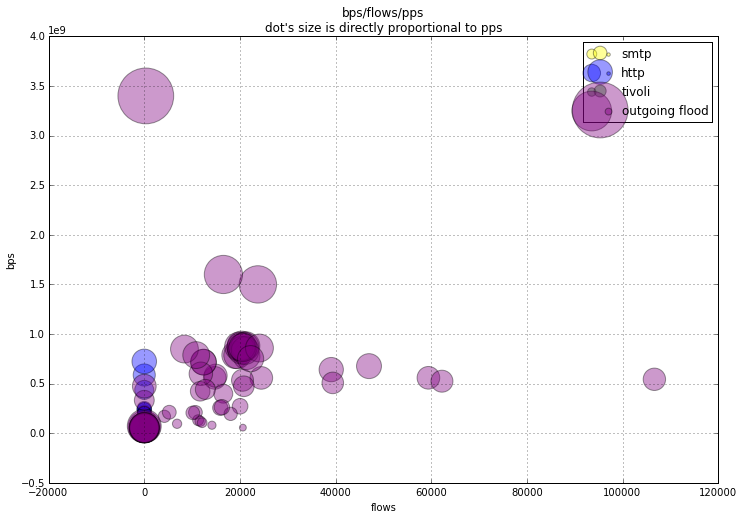

In [14]:
plt.figure(figsize=(12,8), dpi=800)
scale_factor = 0.01
alfa = 0.4
plt.xlabel('flows')
plt.ylabel('bps')

# SMTP label
x, y = smtp_label['flows'], smtp_label['bps']
scale = scale_factor * smtp_label['pps']
plt.scatter(x, y, c='yellow', s=scale, label='smtp',
            alpha=alfa, edgecolors='black'
)
# http label
x, y = http_label['flows'], http_label['bps']
scale = scale_factor * http_label['pps']
plt.scatter(x, y, c='blue', s=scale, label='http',
            alpha=alfa, edgecolors='black'
)
# tivoli label
x, y = tivoli_label['flows'], tivoli_label['bps']
scale = scale_factor * tivoli_label['pps']
plt.scatter(x, y, c='green', s=scale, label='tivoli',
            alpha=alfa, edgecolors='black'
)
# small outgoing flood label
x, y = small_flood_label['flows'], small_flood_label['bps']
scale = scale_factor * small_flood_label['pps']
plt.scatter(x, y, c='purple', s=scale, label='outgoing flood',
            alpha=alfa, edgecolors='black'
)

plt.title('bps/flows/pps\ndot\'s size is directly proportional to pps'
)

plt.legend()
plt.grid(True)

plt.show()

Previosly plotted data is overlapped with flows of incoming DDoS.

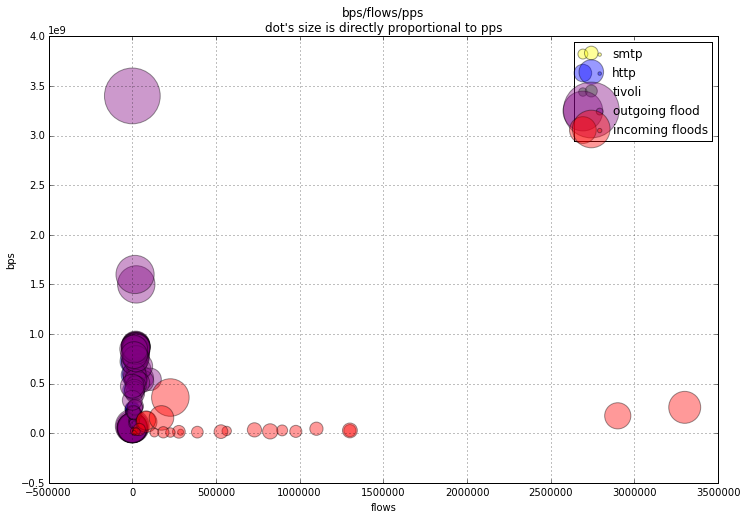

In [18]:
plt.figure(figsize=(12,8), dpi=800)
scale_factor = 0.01
alfa = 0.4
plt.xlabel('flows')
plt.ylabel('bps')

# SMTP label
x, y = smtp_label['flows'], smtp_label['bps']
scale = scale_factor * smtp_label['pps']
plt.scatter(x, y, c='yellow', s=scale, label='smtp',
            alpha=alfa, edgecolors='black'
)
# http label
x, y = http_label['flows'], http_label['bps']
scale = scale_factor * http_label['pps']
plt.scatter(x, y, c='blue', s=scale, label='http',
            alpha=alfa, edgecolors='black'
)
# tivoli label
x, y = tivoli_label['flows'], tivoli_label['bps']
scale = scale_factor * tivoli_label['pps']
plt.scatter(x, y, c='green', s=scale, label='tivoli',
            alpha=alfa, edgecolors='black'
)
# small outgoing flood label
x, y = small_flood_label['flows'], small_flood_label['bps']
scale = scale_factor * small_flood_label['pps']
plt.scatter(x, y, c='purple', s=scale, label='outgoing flood',
            alpha=alfa, edgecolors='black'
)
# incoming floods label
x, y = incoming_floods_label['flows'], incoming_floods_label['bps']
scale = scale_factor * incoming_floods_label['pps']
plt.scatter(x, y, c='red', s=scale, label='incoming floods',
            alpha=alfa, edgecolors='black'
)

plt.title('bps/flows/pps\ndot\'s size is directly proportional to pps')

plt.legend()
plt.grid(True)

plt.show()

## Applying kNN

In [7]:
import mangle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, preprocessing
from sklearn import metrics

n_neighbors = 5
alpha = 0.8
scale = 0.01

X, labels, numeric_labels, labels_dict = mangle.aggregate_netflow_csv(
    "data/smtp.csv",
    "data/http.csv",
    "data/tivoli.csv",
    "data/small-flood.csv",
    "data/incoming-floods.csv",
)
normalized_X = preprocessing.normalize(X)

### Manually check against test samples

Check kNN using manulally labeled samples.

Samples are manually labeled from output of:

`nfdump -l 1K -M $PATH_TO_NFCAP_DATA -r $NFCAP_TARGET_FILE -n 1000 -s record/pps/bps -s dstip/pps/bps -s srcip/pps/bps`

Only `dstip/pps/bps` is used as input data.

In [8]:
denom_neigh = neighbors.NearestNeighbors(n_neighbors=n_neighbors)
denom_neigh.fit(X)
normalized_neigh = neighbors.NearestNeighbors(n_neighbors=n_neighbors)
normalized_neigh.fit(normalized_X) 
test_samples, test_labels, test_numeric_labels, test_labels_dict = mangle.aggregate_netflow_csv(
    "data/test-samples.csv",
)
normalized_test_samples = preprocessing.normalize(test_samples)
with open('data/test-samples-labels.txt') as f:
    test_labels = f.readlines()
with open('data/test-samples.raw') as f:
    test_samples_raw = f.readlines()
for idx, ts in enumerate(test_samples):
    denom_indexes = denom_neigh.kneighbors(ts, return_distance=False)[0]
    normalized_indexes = normalized_neigh.kneighbors(normalized_test_samples[idx], return_distance=False)[0]
    print "raw sample {}:".format(idx+1)
    print "Date first seen          Duration Proto       Dst IP Addr    Flows(%)     Packets(%)       Bytes(%)         pps      bps   bpp"
    print test_samples_raw[idx].replace("\n", "")
    print "label: " + test_labels[idx].replace("\n", "")
    print str(n_neighbors) + " nearest neighbors are (denormalized): " + ", ".join([ labels[i] for i in denom_indexes ])
    print str(n_neighbors) + " nearest neighbors are (normalized): " + ", ".join([ labels[i] for i in normalized_indexes ])
    print '================='

raw sample 1:
Date first seen          Duration Proto       Dst IP Addr    Flows(%)     Packets(%)       Bytes(%)         pps      bps   bpp
2015-03-09 05:18:30.579   387.262 any       XXX.XXX.XXX.XXX       13( 0.0)    2.5 M( 2.2)    3.8 G( 4.6)     6499   77.9 M  1497 
label:  concurrent https sessions
5 nearest neighbors are (denormalized): incoming-flood, tivoli, tivoli, small-flood, tivoli
5 nearest neighbors are (normalized): small-flood, tivoli, small-flood, incoming-flood, http
raw sample 2:
Date first seen          Duration Proto       Dst IP Addr    Flows(%)     Packets(%)       Bytes(%)         pps      bps   bpp
2015-03-10 01:59:06.179   328.155 any       XXX.XXX.XXX.XXX       59( 0.0)    3.1 M( 1.7)    4.7 G( 3.0)     9597  115.1 M  1498 
label:  https traffic
5 nearest neighbors are (denormalized): incoming-flood, tivoli, http, small-flood, small-flood
5 nearest neighbors are (normalized): tivoli, small-flood, small-flood, http, tivoli
raw sample 3:
Date first seen        

### Classification report & Confusion matrix

In [9]:
clf = neighbors.KNeighborsClassifier(n_neighbors)
clf.fit(normalized_X, numeric_labels)
print "### Classifier parameters\n"
print clf
expected = numeric_labels
predicted = clf.predict(normalized_X)
print "\n### Classification Report\n"
print metrics.classification_report(expected, predicted)
print "### Confusion Matrix\n"
conf_matrix = metrics.confusion_matrix(expected, predicted)
# change numpy print format
np.set_printoptions(formatter={'int': '{: 4d}'.format})
for key, value in labels_dict.iteritems():
    print "{:>20}({}): {}".format(value, key, conf_matrix[key-1])
# reset numpy print format
np.set_printoptions()

### Classifier parameters

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform')

### Classification Report

             precision    recall  f1-score   support

          1       0.72      0.55      0.62        93
          2       0.74      0.83      0.78       172
          3       0.76      0.90      0.83        72
          4       0.69      0.57      0.63        63
          5       0.91      0.84      0.87        25

avg / total       0.74      0.74      0.74       425

### Confusion Matrix

                smtp(1): [  51   41    0    1    0]
                http(2): [  20  143    2    7    0]
              tivoli(3): [   0    0   65    5    2]
         small-flood(4): [   0   10   17   36    0]
      incoming-flood(5): [   0    0    1    3   21]


# Conclusions

Despite the limited training dataset, kNN has proven to be effective in clustering aggregated netflow data. Despite the limited training dataset, kNN has proven to be effective in clustering aggregated netflow data as shown in `Classification Report` and `Confusion Matrix`.

Even unknown samples of unlabeled type are reconducted to logically similar labels.

# Disclaimer

This is not an academic research and it doesn't want be formally correct in that sense. 

If you find erros or inaccuracies I'd like to receive corrections even in form of pull requests, issues or any other mean.

# Version

0.1

# Credits

Andrea Masi -
[web](http://eraclitux.com "Website") -
[github](http://github.com/eraclitux "Code") -
[twitter](http://twitter.com/eraclitux "Social")